In [1]:
import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.formula.api as SM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.formula.api as SM
from sklearn.naive_bayes import GaussianNB,MultinomialNB #alpha parameter in multinomialNB is also called Laplace Estimator
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
used_cars = pd.read_csv('ucds.csv')
used_cars.head()

,ID,Region,manufacturer,model,version,months_old,power,condition,num_owners,transmission,Fuel,odometer,price,Original_price,Lat,Long,Posting_date
0,97860.0,auburn,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999.0,1043526.0,32.5900,-85.480000,2021-05-04T10:41:31-0500
1,27821.0,auburn,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000.0,719256.0,32.6013,-85.443974,2021-05-03T12:12:59-0500
2,97801.0,auburn,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555.0,599082.0,32.6454,-85.378300,2021-05-03T07:38:05-0500
3,98251.0,auburn,Porsche,911,R Unidad 343 De 991-Iva Deducible,14.0,368.0,used,1.0,manual,gasoline,2800.0,470000.0,513527.0,32.5900,-85.480000,2021-05-02T12:22:10-0500
4,98250.0,auburn,Porsche,911,Gt2 Rs,3.0,515.0,used,NaN,NaN,gasoline,10.0,450000.0,493527.0,32.5900,-85.480000,2021-05-02T08:44:35-0500


# Cleaning Data

In this section, cleaning out nulls and duplicates from data. Filled some of the nulls with 'unknown'. I am assuming that these people ("unknown) chose not or forgot to specify these categories while listing their cars on the website.

I also drop 4 columns 'Lat','Long','Posting_date','version','num_owners','condition' as they are not beneficial variables for the purpose of predicting the price of used cars.|

In [4]:
used_cars.columns
print(used_cars.isnull().sum())

ID                  947
Region              947
manufacturer        947
model               947
version             947
months_old         1221
power              1434
condition           959
num_owners        72278
transmission       2228
Fuel               1012
odometer           1811
price               947
Original_price      947
Lat                1654
Long               1654
Posting_date        947
dtype: int64


In [5]:
fill_na_values = {
    'Fuel':'unknown',
    'transmission':'unknown',
    'Region':'unknown',
    'model':'unknown'   
}

used_cars.fillna(value=fill_na_values, inplace=True)

print(used_cars.isnull().sum())


ID                  947
Region                0
manufacturer        947
model                 0
version             947
months_old         1221
power              1434
condition           959
num_owners        72278
transmission          0
Fuel                  0
odometer           1811
price               947
Original_price      947
Lat                1654
Long               1654
Posting_date        947
dtype: int64


In [6]:
used_cars.drop(columns=['Lat','Long','Posting_date','version','num_owners','condition'],inplace=True)

In [7]:
used_cars.drop_duplicates(inplace=True)

In [8]:
used_cars.columns
print(used_cars.isnull().sum())

ID                  1
Region              0
manufacturer        1
model               0
months_old        275
power             488
transmission        0
Fuel                0
odometer          865
price               1
Original_price      1
dtype: int64


In [9]:
used_cars.dropna(inplace=True)
print(used_cars.isnull().sum())

ID                0
Region            0
manufacturer      0
model             0
months_old        0
power             0
transmission      0
Fuel              0
odometer          0
price             0
Original_price    0
dtype: int64


# EDA

In this section, changing the months_old column to a more interpretable format (Resampling dates). I converted the months_old column to an "age" column which represents the model year of the car. (i.e. If you are selling a 2006 Honda, the age column would say "2006" instead of 144 months old.

In addition, I also remove outliers from the data such as brand new cars with 0 odometer i.e. mileage. Note: I don't remove outliers for the price and other columns as the goal of my project is to predict the price of any car, essentially to allow my mode to able to generalize on any kind of unseen data.

I then start to plot out different distributions data to better understand its underlying distribution and gain a better understanding of how I want to approach feature engineering for my models.

In [10]:
used = used_cars[(used_cars['odometer'] > 0)]
used['months_old'].astype(int)
twelve = np.ceil((used.months_old/12)).astype(float) # round up some are less than 1 month old
used_new = pd.merge(used,twelve.to_frame(),left_index=True,right_index=True)
used_new.drop(columns=['months_old_x'],inplace=True)
used_new.rename(columns={'months_old_y':'age'}, inplace=True) # age is the year of model of the vehicle
used_new = used_new[(used_new['age'] < 32.0)]
year = (2023-used_new.age).to_frame()
used_new = pd.merge(used,year,left_index=True,right_index=True)

In [11]:
print(used_new.age.unique())


[2003. 2018. 1993. 2021. 2022. 2020. 2002. 1997. 2010. 2019. 2015. 2016.
 2007. 2014. 2017. 2005. 2012. 2011. 1995. 1992. 2001. 2013. 2000. 1999.
 2008. 2009. 1996. 1998. 2006. 1994. 2004.]


In [12]:
used_new.head()

,ID,Region,manufacturer,model,months_old,power,transmission,Fuel,odometer,price,Original_price,age
0,97860.0,auburn,Porsche,911,240.0,210.0,manual,gasoline,202000.0,999999.0,1043526.0,2003.0
1,27821.0,auburn,Ford,Mustang,54.0,487.0,manual,gasoline,30000.0,685000.0,719256.0,2018.0
2,97801.0,auburn,Porsche,911,358.0,220.0,manual,gasoline,56300.0,555555.0,599082.0,1993.0
3,98251.0,auburn,Porsche,911,14.0,368.0,manual,gasoline,2800.0,470000.0,513527.0,2021.0
4,98250.0,auburn,Porsche,911,3.0,515.0,unknown,gasoline,10.0,450000.0,493527.0,2022.0


# Distribution Plots

In this section, I assess how the "numeric/continuous" independent variables are distributed. I also inspect the frequencies for my categorical variables.

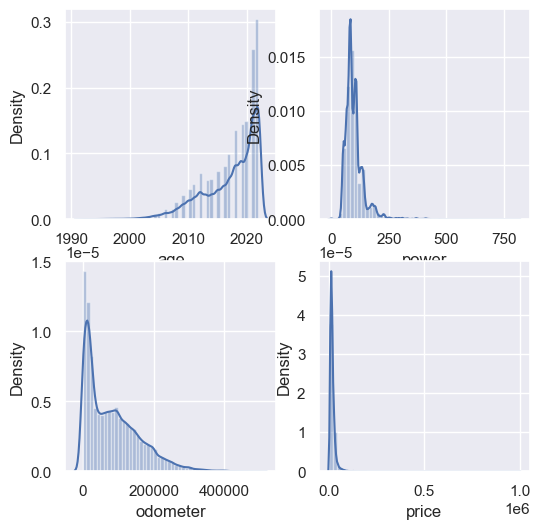

In [13]:
# Plotting out distributions for the numeric variables to see whether they are normally distributed
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(ncols=2,nrows=2,figsize=(6,6)) 
sns.distplot(used_new['age'],ax=ax1);
sns.distplot(used_new['power'],ax=ax2);
sns.distplot(used_new['odometer'],ax=ax3);            
sns.distplot(used_new['price'],ax=ax4);

# Frequency Plots

Frequency of the different categorical variables to get a better understanding of their distribution and potentially drop some variables that may act as outliers.

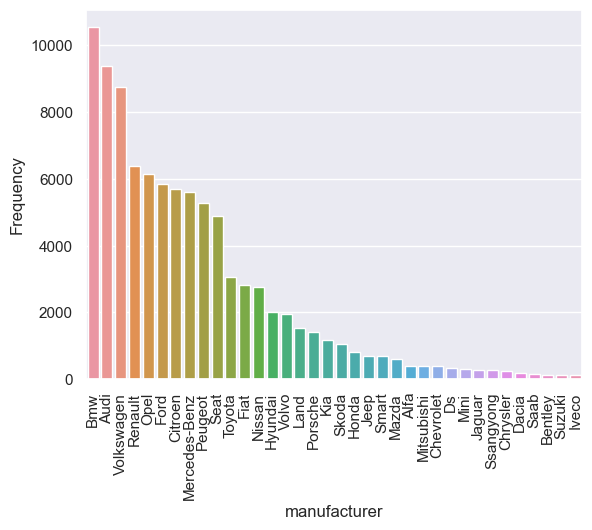

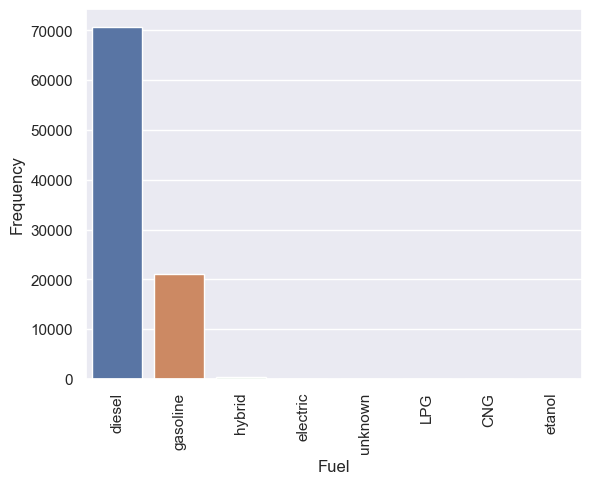

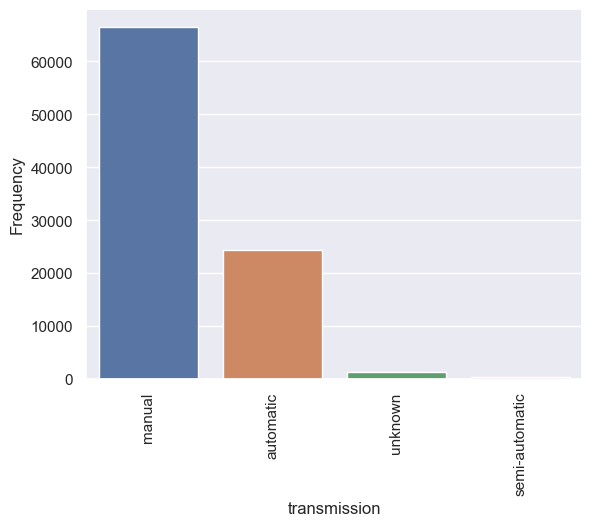

In [14]:
categories = ['manufacturer','Fuel', 'transmission'] # categorical features used in my analysis
ranges = [0,1,2,3,4] 
counts = []
x = []
y = []
for i,j in zip(ranges,categories):
    z = used_new.groupby([j])['ID'].count().sort_values(ascending=False).reset_index()
    counts.append(z)
    x.append(counts[i][j])
    y.append(counts[i]['ID'])
    plt.figure()
    sns.barplot(x[i],y[i])
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)

# Further Cleaning & Preprocessing

- Based off the above frequency plots, some categories may act "outliers" due to very low counts.
- Drop two fuel_type categories, etanol & CNG. (low frequency, very imbalanced)
- Kept all of the categories within gear type.
- Then clean the outcome variable column 'price', from any outliers such as cars priced over 400,000 euros or less than 0 euros.


Cleaning Fuel Type

In [15]:
print(used_new.groupby(['Fuel'])['ID'].count().sort_values(ascending=True).reset_index())

       Fuel     ID
0    etanol      1
1       CNG      3
2       LPG     43
3   unknown     53
4  electric     92
5    hybrid    470
6  gasoline  21028
7    diesel  70699


In [16]:
et = used_new[(used_new['Fuel']=='etanol')].index
cng = used_new[(used_new['Fuel']=='CNG')].index
used_new.drop(et,axis=0,inplace=True) # etanol 
used_new.drop(cng,axis=0,inplace=True) # CNG 
print(used_new.groupby(['Fuel'])['ID'].count().sort_values(ascending=True).reset_index())

       Fuel     ID
0       LPG     43
1   unknown     53
2  electric     92
3    hybrid    470
4  gasoline  21028
5    diesel  70699


Cleaning Gear Type

In [17]:
print(used_new.groupby(['transmission'])['ID'].count().sort_values(ascending=True).reset_index())

     transmission     ID
0  semi-automatic    292
1         unknown   1234
2       automatic  24275
3          manual  66584


Not too often, so I'll continue using the semi-automatic rows.

Cleaning Price

In [18]:
used_new = used_new.drop(used_new[used_new.price>900000].index)

Integrating more data - Countries

In [19]:
#Added countries to the data to increase the amount of data and do some more analysis at the country-level.
#Here, each car maker gets a corresponding country assigned.
Germany = {'Audi','Bmw','Mercedes-Benz','Skoda','Porsche','Smart','Volkswagen','Opel'}
Italy = {'Fiat','Iveco','Alfa'}
USA = {'Ford','Jeep','Chrysler','Chevrolet'}
Japan = {'Honda','Nissan','Suzuki','Ssangyong','Hyundai','Mitsubishi','Mazda','Toyota','Kia'}
Spain ={'Seat'}
Romania= {'Dacia'}
France={'Renault','Peugeot','Citroen','Ds'}
Sweden = {'Volvo','Saab'}
UK = {'Land','Jaguar','Mini','Bentley'}

mydata = {'Germany':Germany, 'Italy':Italy, 'USA':USA, "Japan":Japan, 'Spain':Spain, 'Romania':Romania, 'France':France,\
          'Sweden':Sweden, 'UK':UK}

mydicts = [{(z,i) for z in j} for i,j in mydata.items()]
mydict = {}
[mydict.update(i) for i in mydicts]
used_new['Country'] = used_new['manufacturer'].map(mydict)

# Part 3 - Visualization

# Distribution of Price per Year

- Age of the car affects the price, where newer cars are higher in price and older cars tend to be lower in price. An interesting point to note is that cars before 1990 are really high in price, which may suggest the existence of classic cars (note: error bars are really high, very few old cars in the dataset with high variance in prices).

# Distribution of Price per Country

Country Level Analysis

- Add the country in which each car was manufactured to my dataset to try to pull out some interesting results. Repeat the distribution of Price but instead use country to see if cars manufactured in different countries are more expensive than cars from other countries.

Statistical Analysis

- We chose to do a one-way ANOVA as working with the price means for each year/sample. Followed this up with Tukey's honest significance test to find which specific pairwise means are signifcantly different from each other (adjusts p_values).

# Distribution of Mileage per Car Maker/Country

Statistical Analysis

- Please note that we only highlight one car maker of interest as we use that as an example in the presentation. Followed up post-hoc analysis for small things that were cool to add in the presentation. It is interesting to find a bus manufacturer (Iveco) has siginificantly higher mileage relative to all the other car makers.

# Distribution of Horsepower per Car Maker/Country

Statistical Analysis (Country)

- Please note that we only highlight one country of interest as we use that as an example in my presentation. It is interesting to see that the UK has significantly higher horsepower cars relative to the other countries. The cars from the UK in this dataset are relatively luxury (Jaguar, Bentley and Land Rover). We would've expected Italy because of cars like Ferrari and Lamborghini, but these car makers are not in the dataset.

In [20]:
# Prepare columns for barplot
used_new = used_new.drop(used_new[used_new.price>900000].index)
yearly_price = used_new.groupby(['age'])['price'].mean().reset_index()
sem_price = used_new.groupby(['age'])['price'].sem().reset_index()

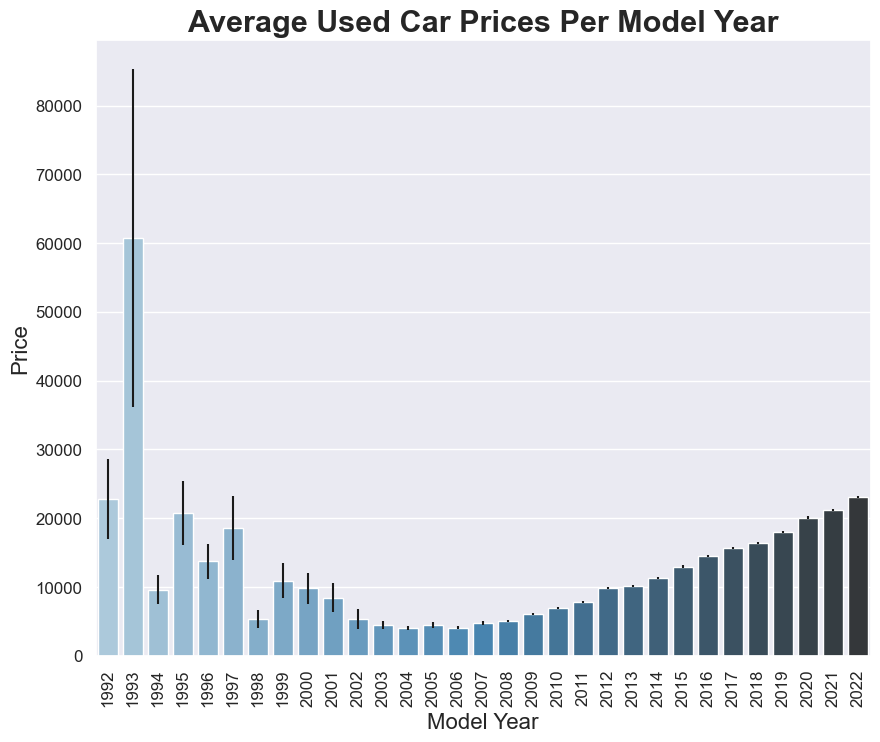

In [21]:
plt.figure(figsize=(10, 8));
sns.set_style("ticks", {"xtick.major.size": 16, "ytick.major.size":8});
sns.set(font_scale=1.1)
fig = sns.barplot(x=yearly_price['age'].astype(int),y= yearly_price['price'], yerr=sem_price['price'],capsize=4,errwidth=3,palette="Blues_d")
plt.ylabel('Price',fontsize=16);
plt.xlabel('Model Year',fontsize=16);
plt.xticks(rotation=90)
plt.title('Average Used Car Prices Per Model Year',fontsize=22,fontweight='bold');
#sns.savefig("Average Used Car Price Per Year.png")
plt.savefig('pricect.png', dpi=400)

Inspecting the counts in the age/year column for cars older than 1995

In [22]:
print(used_new[(used_new['age']<1995)].groupby('age')['ID'].count().reset_index())

      age  ID
0  1992.0  30
1  1993.0  24
2  1994.0  25


What are the cars in 1993 that are making the barplot look like this ?

- Looks like there are just a lot of expensive classics in 1993 and some very cheap cars (3250) which is why we see such a large spike with such a large error bar.

In [23]:
used_new[(used_new['age']== 1993)]

,ID,Region,manufacturer,model,months_old,power,transmission,Fuel,odometer,price,Original_price,age,Country
2,97801.0,auburn,Porsche,911,358.0,220.0,manual,gasoline,56300.0,555555.0,599082.0,1993.0,Germany
65,97799.0,birmingham,Porsche,911,360.0,220.0,manual,gasoline,33000.0,195000.0,238527.0,1993.0,Germany
66,97800.0,birmingham,Porsche,911,360.0,220.0,manual,gasoline,30000.0,195000.0,238527.0,1993.0,Germany
271,97798.0,birmingham,Porsche,911,356.0,220.0,manual,gasoline,147000.0,119900.0,163427.0,1993.0,Germany
298,97797.0,dothan,Porsche,911,356.0,169.0,manual,gasoline,215000.0,115000.0,158527.0,1993.0,Germany
706,97796.0,mobile,Porsche,911,357.0,202.0,unknown,gasoline,169000.0,79000.0,122527.0,1993.0,Germany
8782,82814.0,redding,Land,RoverRangeRover,350.0,93.0,manual,gasoline,54000.0,30000.0,73527.0,1993.0,UK
13178,82806.0,ventura county,Land,RoverRangeRover,352.0,134.0,automatic,gasoline,98000.0,26000.0,69527.0,1993.0,UK
29447,82779.0,indianapolis,Land,RoverRangeRover,359.0,88.0,manual,diesel,147000.0,17900.0,61427.0,1993.0,UK
30125,14422.0,des moines,Bmw,320,354.0,95.0,automatic,gasoline,152000.0,17800.0,44679.0,1993.0,Germany


Text(0.5, 1.0, 'Price per Country')

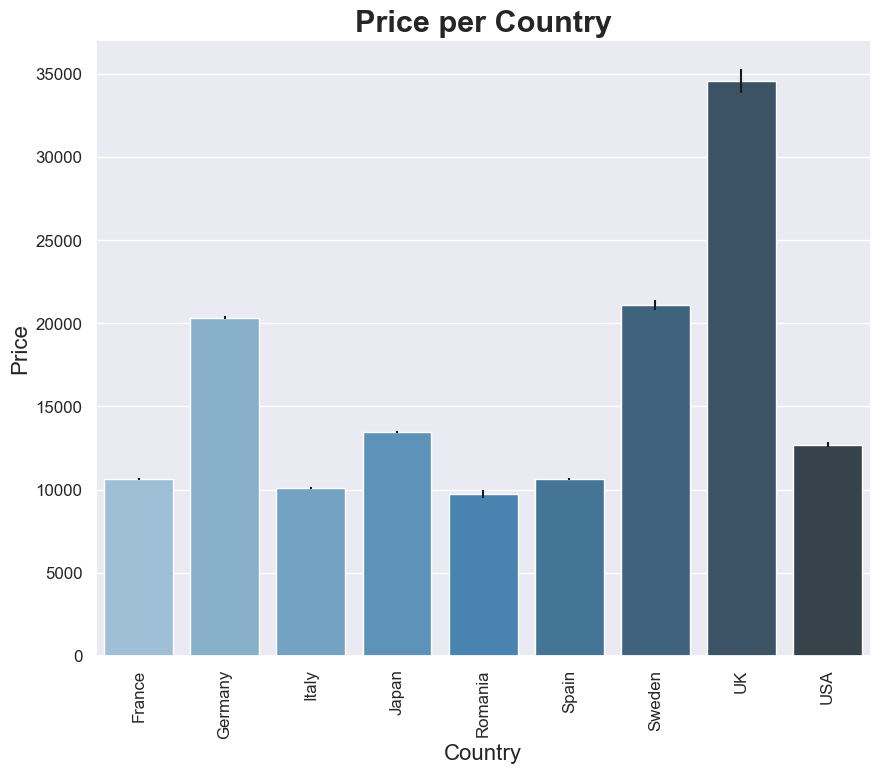

In [24]:
import numpy as np  # Import NumPy for calculations

# Calculate the standard error of 'price' for each 'Country'
sem_price = used_new.groupby(['Country'])['price'].sem().reset_index()

# Calculate the mean price for each 'Country'
mean_price = used_new.groupby(['Country'])['price'].mean().reset_index()

# Plot the bar chart with error bars
plt.figure(figsize=(10, 8))
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 10})
sns.set(font_scale=1.1)
fig = sns.barplot(x=mean_price['Country'], y=mean_price['price'], 
                  yerr=sem_price['price'], errwidth=3, palette="Blues_d")
plt.ylabel('Price', fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Price per Country', fontsize=22, fontweight='bold')


# ANOVA

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

cprice = used_new[['Country','price']]
cprice_lm = ols('price ~ Country', data=cprice).fit()
print(anova_lm(cprice_lm))
df = pairwise_tukeyhsd(cprice['price'], cprice['Country']).summary()
print(df)


               df        sum_sq       mean_sq            F  PR(>F)
Country       8.0  2.544346e+12  3.180432e+11  1556.089252     0.0
Residual  92375.0  1.888018e+13  2.043862e+08          NaN     NaN
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1  group2   meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------
 France Germany   9706.2131    0.0   9310.8256  10101.6006   True
 France   Italy   -535.6725  0.553  -1372.1803    300.8353  False
 France   Japan   2828.0487    0.0   2292.7848   3363.3126   True
 France Romania   -906.9847 0.9939  -4091.9524    2277.983  False
 France   Spain     18.8534    1.0   -697.0246    734.7315  False
 France  Sweden   10472.868    0.0   9452.3948  11493.3412   True
 France      UK  23924.0309    0.0  22928.5382  24919.5237   True
 France     USA   2072.3416    0.0   1451.0204   2693.6628   True
Germany   Italy -10241.8856    0.0 -11037.9647  -9445.8065   True
Germany

# Distribution of Mileage per Make --> Are some cars driven more than others ?

- Here, I compare the difference in distribution of mileage for different makes of cars in my dataset. I observe interesting things like Iveco with the most mileage covered in distribution. This makes sense as Iveco is a Bus manufacturer !

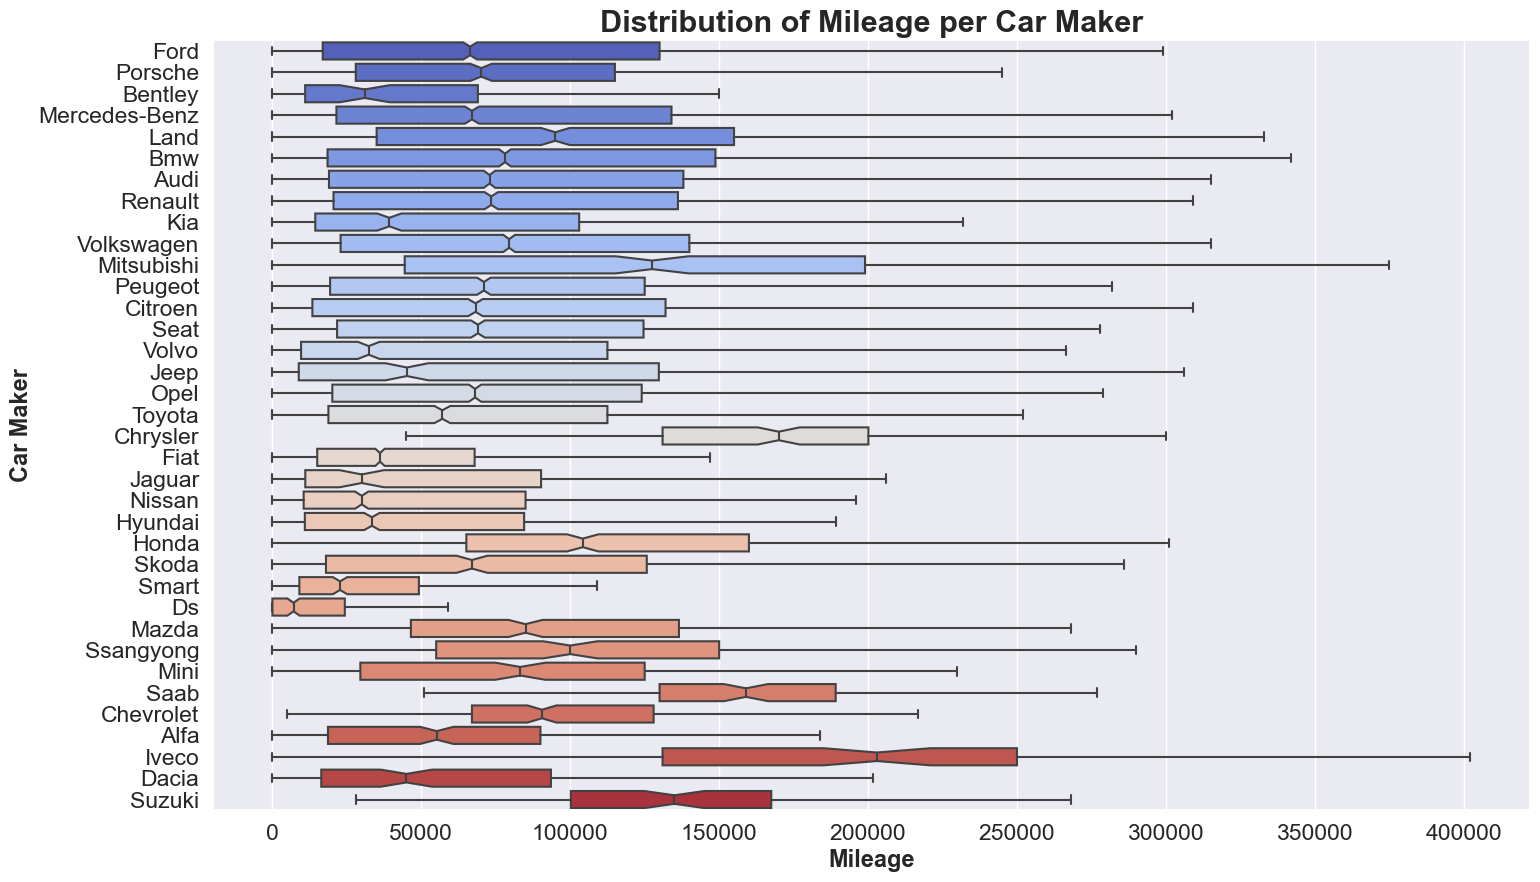

In [26]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(17, 10));
plot = sns.boxplot(x='odometer',y='manufacturer',data=used_new,notch=True,orient='h',palette="coolwarm",showfliers=False)
plt.xlabel('Mileage',fontsize=17,fontweight="bold")
plt.ylabel('Car Maker',fontsize=17,fontweight="bold")
plt.title('Distribution of Mileage per Car Maker',fontsize=22,fontweight="bold")
plt.xlim()
plt.savefig('mileagect.png')
plt.show()

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

mprice = used_new[['odometer','manufacturer']]
mprice_lm = ols('odometer ~ manufacturer', data=mprice).fit()
print(anova_lm(mprice_lm))
tukey_mprice = pairwise_tukeyhsd(mprice['odometer'], mprice['manufacturer']).summary()
print(tukey_mprice)


                   df        sum_sq       mean_sq           F  PR(>F)
manufacturer     35.0  2.141718e+13  6.119194e+11  112.694629     0.0
Residual      92348.0  5.014394e+14  5.429890e+09         NaN     NaN
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
    group1        group2      meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------------
         Alfa          Audi   29169.6544    0.0   14767.0348    43572.274   True
         Alfa       Bentley  -13223.1888 0.9995  -42926.7416    16480.364  False
         Alfa           Bmw    33591.342    0.0   19221.8584   47960.8256   True
         Alfa     Chevrolet   39423.4379    0.0   19312.5572   59534.3186   True
         Alfa      Chrysler  113110.9853    0.0   89922.5211  136299.4496   True
         Alfa       Citroen   23205.9552    0.0    8612.9753    37798.935   True
         Alfa         Dacia       92.547    1.0  -24541.7518 

In [28]:
tukey_df = pd.DataFrame(tukey_mprice.data,columns=['group1','group2','meandiff','p-adj','lower','upper','reject'])
tukey_df[((tukey_df['group1']== 'Iveco') | (tukey_df['group2']== 'Iveco'))]

,group1,group2,meandiff,p-adj,lower,upper,reject
13,Alfa,Iveco,136593.8078,0.0,106057.6177,167129.9978,True
47,Audi,Iveco,107424.1533,0.0,80182.7532,134665.5535,True
80,Bentley,Iveco,149816.9965,0.0,112174.4743,187459.5188,True
112,Bmw,Iveco,103002.4658,0.0,75778.5702,130226.3613,True
143,Chevrolet,Iveco,97170.3698,0.0,66525.5341,127815.2056,True
173,Chrysler,Iveco,23482.8224,0.677,-9264.1363,56229.7812,False
202,Citroen,Iveco,113387.8526,0.0,86045.3309,140730.3743,True
230,Dacia,Iveco,136501.2608,0.0,102715.0637,170287.4578,True
257,Ds,Iveco,179783.007,0.0,148745.5662,210820.4478,True
283,Fiat,Iveco,144317.699,0.0,116716.7508,171918.6472,True


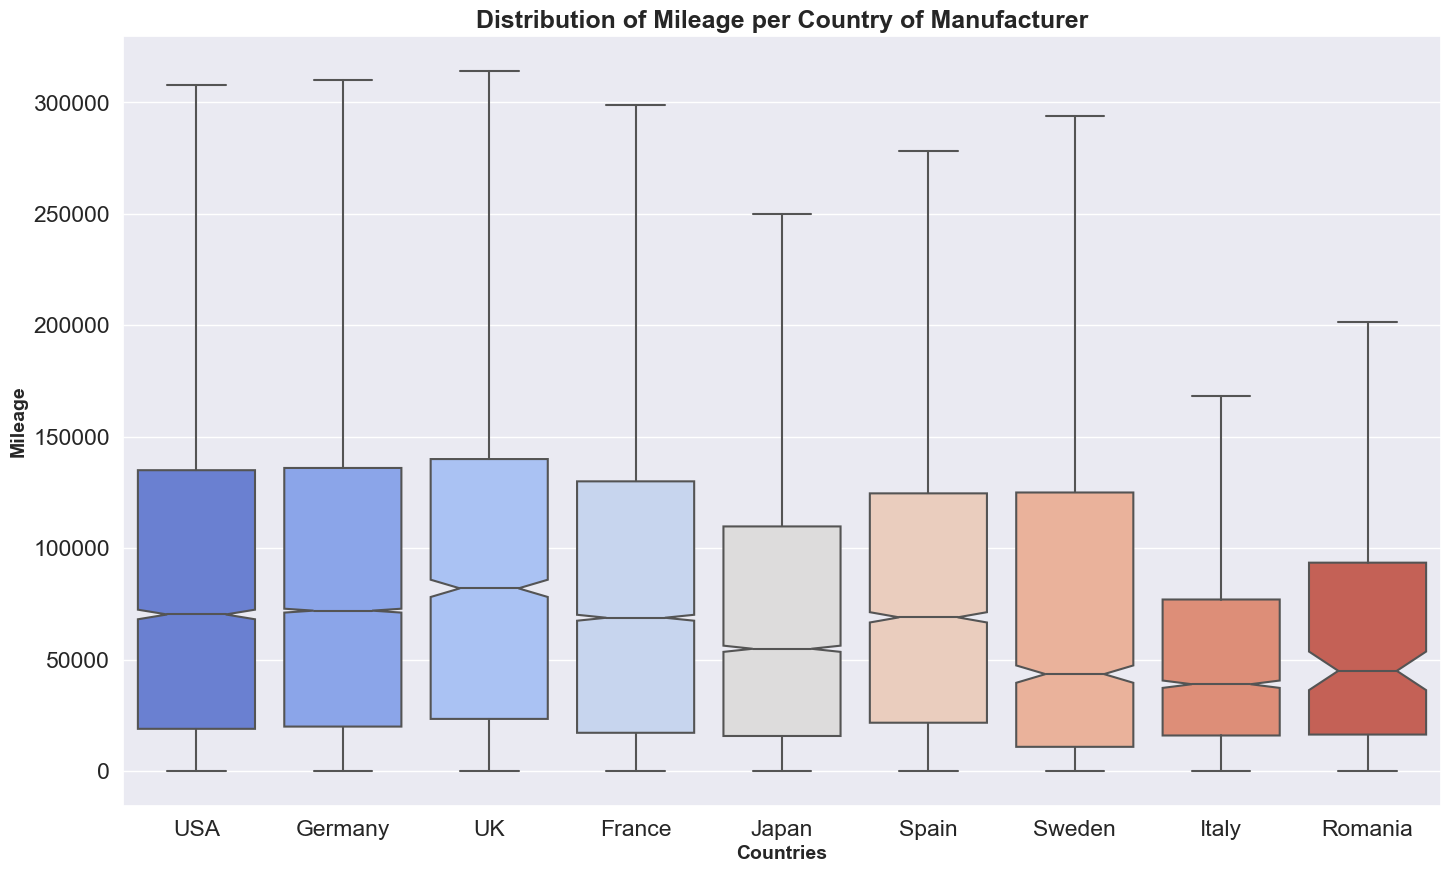

In [29]:
plt.figure(figsize=(17, 10));
sns.boxplot(x='Country',y='odometer',data=used_new,notch=True,palette="coolwarm",showfliers=False)
plt.xlabel('Countries',fontsize=14,fontweight="bold")
plt.ylabel('Mileage',fontsize=14,fontweight="bold")
plt.title('Distribution of Mileage per Country of Manufacturer',fontsize=18,fontweight="bold")
plt.xlim()
plt.show()

# ANOVA

In [30]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Your previous code to create cprice_lm using ols

print(anova_lm(cprice_lm))

# Use pairwise_tukeyhsd directly on the fitted model
tukey_results = pairwise_tukeyhsd(cprice_lm.resid, cprice['Country'])

# Print the summary
print(tukey_results.summary())


               df        sum_sq       mean_sq            F  PR(>F)
Country       8.0  2.544346e+12  3.180432e+11  1556.089252     0.0
Residual  92375.0  1.888018e+13  2.043862e+08          NaN     NaN
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2 meandiff p-adj   lower      upper   reject
----------------------------------------------------------
 France Germany     -0.0   1.0  -395.3875  395.3875  False
 France   Italy      0.0   1.0  -836.5078  836.5078  False
 France   Japan      0.0   1.0  -535.2639  535.2639  False
 France Romania     -0.0   1.0 -3184.9677 3184.9677  False
 France   Spain     -0.0   1.0  -715.8781  715.8781  False
 France  Sweden      0.0   1.0 -1020.4732 1020.4732  False
 France      UK      0.0   1.0  -995.4927  995.4927  False
 France     USA      0.0   1.0  -621.3212  621.3212  False
Germany   Italy      0.0   1.0  -796.0791  796.0791  False
Germany   Japan      0.0   1.0  -469.5786  469.5786  False
Germany Romania      0.0   1.0 -

# What makes of cars have the highest horsepower ? Is the power associated with price ?

- In terms of horsepower, we see a pretty reasonable effect in terms of distribution. Bentley ranks at #1, Porsche at #2, some Mercedes-Benz Cars at #3, and Land Rovers and Jaguars around #4.

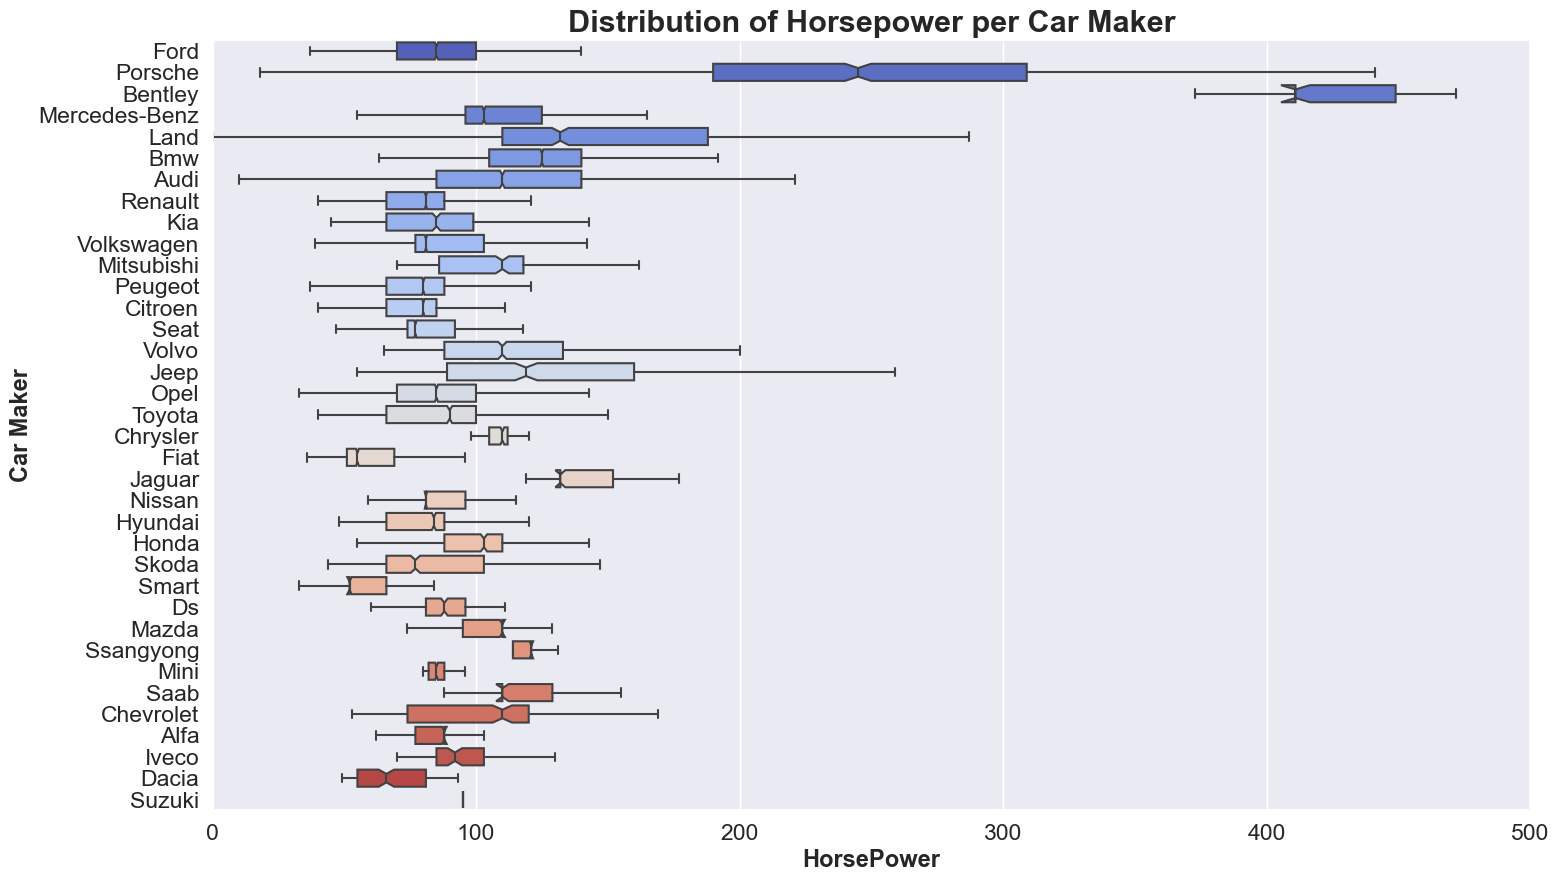

In [31]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(17, 10));
sns.boxplot(x='power',y='manufacturer',data=used_new,notch=True,orient='h',palette='coolwarm',showfliers=False)
plt.xlabel('HorsePower',fontsize=17,fontweight="bold")
plt.ylabel('Car Maker',fontsize=17,fontweight="bold")
plt.title('Distribution of Horsepower per Car Maker',fontsize=22,fontweight="bold")
plt.xlim(0,500)
plt.show()

Country Level Analysis of Horsepower

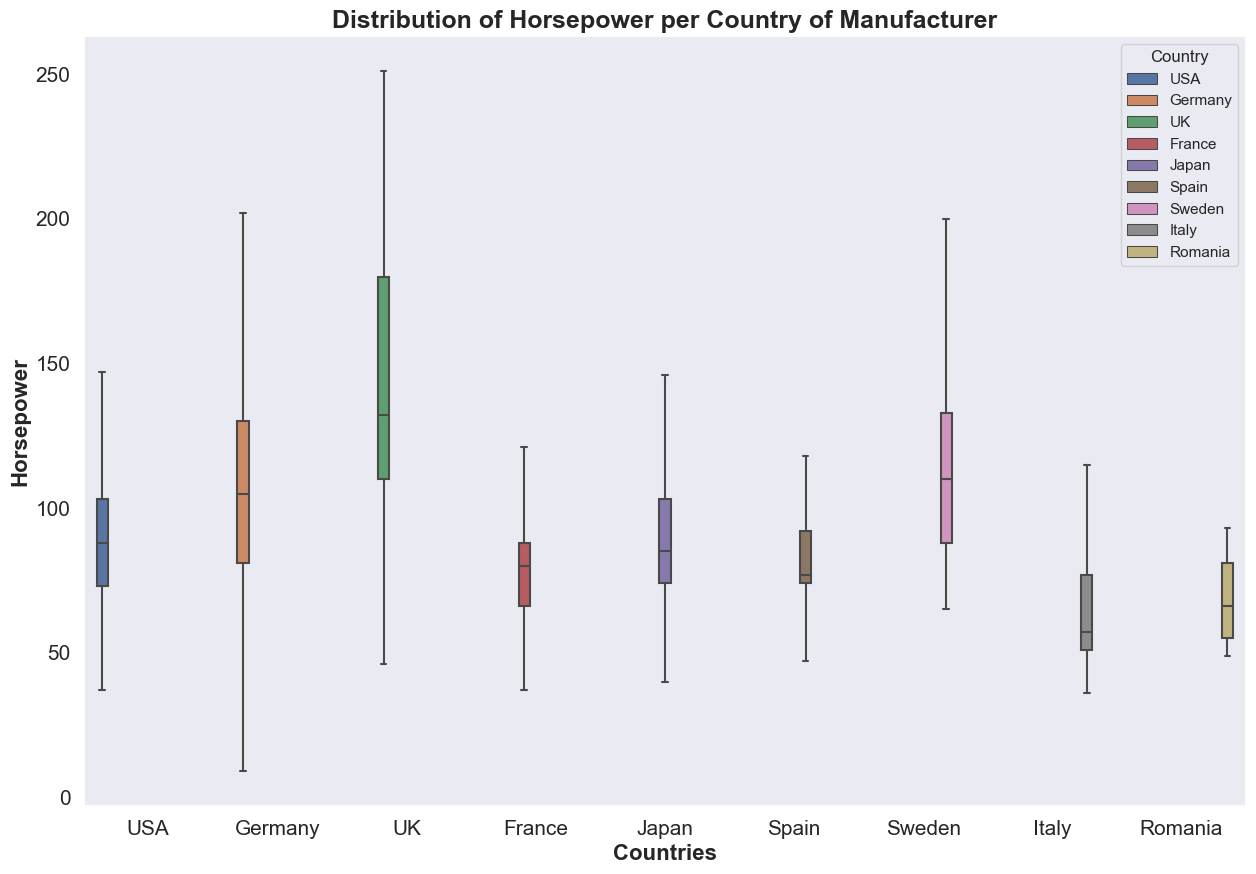

In [32]:
sns.set(style='dark')
plt.figure(figsize=(15, 10));
sns.boxplot(x='Country',y='power',data=used_new,showfliers=False,hue='Country')
plt.xlabel('Countries',fontsize=16,fontweight="bold")
plt.ylabel('Horsepower',fontsize=16,fontweight="bold")
plt.title('Distribution of Horsepower per Country of Manufacturer',fontsize=18,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim()
plt.savefig('hpct.png',dpi=400)
plt.show()

In [33]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pprice = used_new[['Country', 'power']]
pprice_lm = ols('power ~ Country', data=pprice).fit()
print(anova_lm(pprice_lm))

# Use pairwise_tukeyhsd directly on the fitted model
pt = pairwise_tukeyhsd(pprice_lm.resid, pprice['Country'])

# Print the summary
print(pt.summary())


               df        sum_sq       mean_sq            F  PR(>F)
Country       8.0  2.955261e+07  3.694076e+06  2450.243364     0.0
Residual  92375.0  1.392679e+08  1.507636e+03          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower  upper  reject
----------------------------------------------------
 France Germany      0.0   1.0 -1.0739 1.0739  False
 France   Italy     -0.0   1.0 -2.2719 2.2719  False
 France   Japan      0.0   1.0 -1.4538 1.4538  False
 France Romania     -0.0   1.0 -8.6502 8.6502  False
 France   Spain     -0.0   1.0 -1.9443 1.9443  False
 France  Sweden     -0.0   1.0 -2.7716 2.7716  False
 France      UK     -0.0   1.0 -2.7037 2.7037  False
 France     USA      0.0   1.0 -1.6875 1.6875  False
Germany   Italy     -0.0   1.0 -2.1621 2.1621  False
Germany   Japan      0.0   1.0 -1.2754 1.2754  False
Germany Romania     -0.0   1.0  -8.622  8.622  False
Germany   Spain     -0.0   1.0 -1.8148 1.8148  False
Germ

In [34]:
# Extract the results from pairwise_tukeyhsd
power_tukey_results = pt.summary()

# Convert the results to a DataFrame
power_tukey = pd.DataFrame(power_tukey_results.data, columns=power_tukey_results.data[0])

# Now you can filter the DataFrame as needed
uk_comparison = power_tukey[(power_tukey['group1'] == 'UK') | (power_tukey['group2'] == 'UK')]
print(uk_comparison)


     group1 group2 meandiff p-adj   lower   upper reject
7    France     UK     -0.0   1.0 -2.7037  2.7037  False
14  Germany     UK     -0.0   1.0 -2.6121  2.6121  False
20    Italy     UK     -0.0   1.0 -3.2911  3.2911  False
25    Japan     UK     -0.0   1.0 -2.7899  2.7899  False
29  Romania     UK     -0.0   1.0  -8.972   8.972  False
32    Spain     UK     -0.0   1.0 -3.0741  3.0741  False
34   Sweden     UK     -0.0   1.0  -3.654   3.654  False
36       UK    USA      0.0   1.0 -2.9185  2.9185  False


# What cars are most frequent in the dataset?

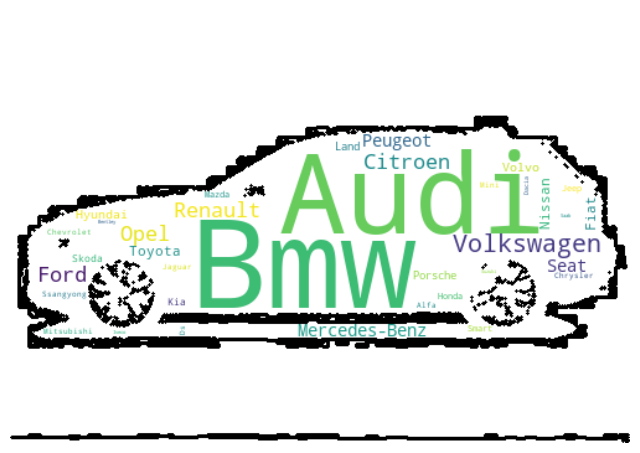

In [35]:
from PIL import Image
from collections import Counter  # Import Counter from collections module
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Some fun Visualizations
# Generate frequencies using counter
freqs = Counter(used_new['manufacturer'])
df = pd.DataFrame.from_dict(freqs, orient='index').reset_index()
df.columns = ['brands', 'freqs']

# Generate image
car_mask = np.array(Image.open('/Users/rohith-9641/Downloads/47.jpg'))

# Generate a word cloud with freqs
wc = WordCloud(background_color="white", max_words=1000, mask=car_mask, contour_width=2, contour_color='black')
wc.generate_from_frequencies(freqs)

plt.figure(figsize=(8, 8))
plt.axis("off")
make = used_new.groupby(['manufacturer'])['ID'].count().sort_values(ascending=False).reset_index()
plt.savefig('wordcloudcar.png')
plt.imshow(wc, interpolation='bilinear')
plt.show()  # Display the word cloud


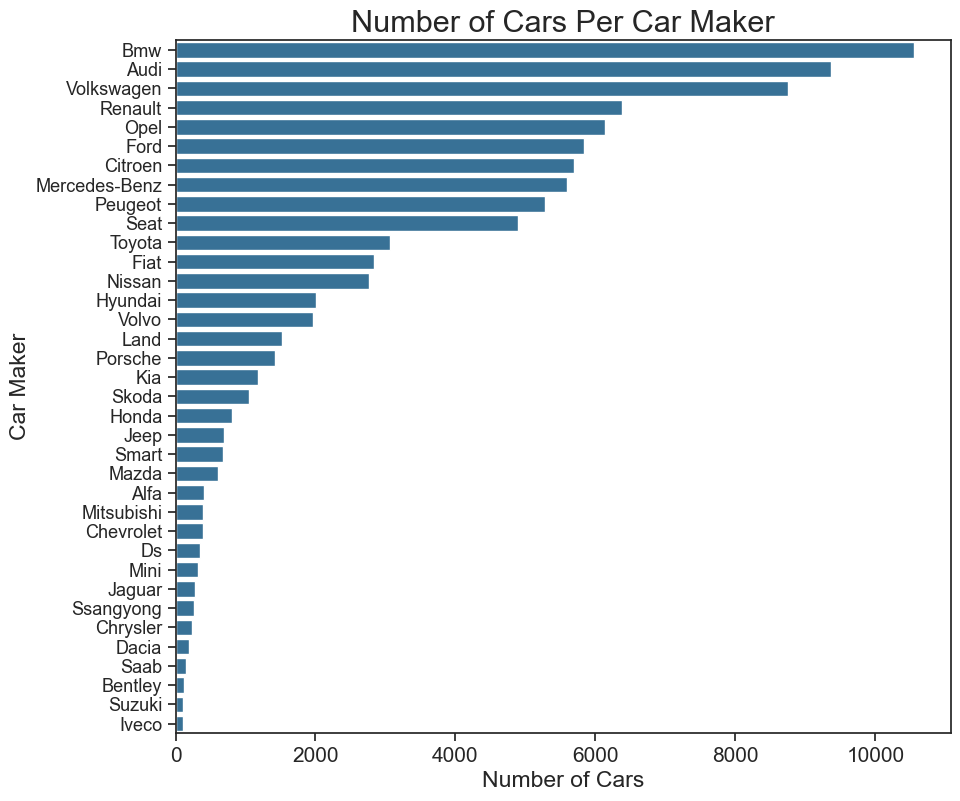

In [36]:
sns.set(font_scale = 1.25)
plt.figure(figsize=(10, 9));
sns.set_style("ticks",{"xtick.major.size": 12, "ytick.major.size":8})
make = used_new.groupby(['manufacturer'])['ID'].count().sort_values(ascending=False).reset_index();
sns.barplot(make['ID'],make['manufacturer'],orient='h',color="#2874A6");
plt.title("Number of Cars Per Car Maker",fontsize=22)
plt.ylabel('Car Maker',fontsize=16.5)
plt.xlabel('Number of Cars',fontsize=16.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.savefig('numberofcarzz.png')
plt.show()

Assessing the correlation coefficients of the numeric variables

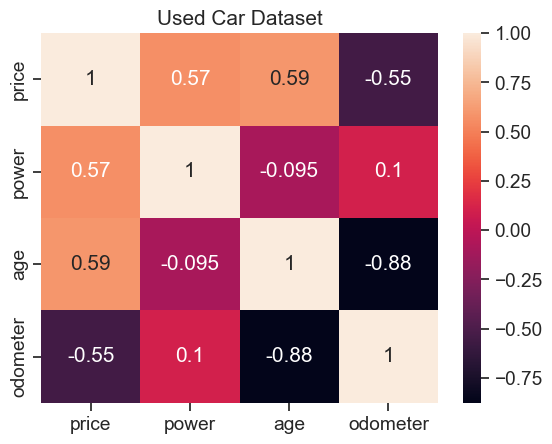

In [37]:
numeric_corr = used_new[['price','power','age','odometer']].corr(method='spearman'); # non-parametric
sns.heatmap(numeric_corr,annot=True);
plt.title('Used Car Dataset');

# Part 4 - Machine Learning Models

- In this section, we test out 5 different regression models on the dataset. We don't do K fold or any standard form of cross validation for the first 3 models as it would take a lot of time and processing power.


- For the Decision tree Regressor and the KNN regressor, we just test out a range of values for the max_depth and number of neighbors and plot out the scores for the train/test values. we select the hyperparameter that don't result in overfitting and that return a good score on the test set. (small differences between training and testing sets --> better at generalizing) (essentially finding the right bias variance tradeoff)


- For the Xgboost and Random Forest Regressor, we optimized the hyperparameters using a randomized search cross validation and each took about one to two days to run. Note: the Xgboost was a lot slower to optimize hence why there are less parameters in the randomized search specific to the Xgboost regressor. Due to a lot of the heavy processing, we had to restart my kernel a couple times and didn't rerun the randomized search CVs but we saved the that the CV returned.


- Lastly, we just test out neural networks(Keras) as a proof of concept that simple networks can be used in predictive modelling for car valuation.


- Metrics: We use the R-Squared to determine which model we will use for deployment. We also use the Root Mean Squared error as it reflects the units of the outcome variable (price).

In [38]:
used_X = used_new[['manufacturer','model','age','transmission','Fuel','power','odometer','Country']]
le_features = used_new[['power','age','odometer']]
# Dummy Categorical Variables 
used_X = pd.concat([used_X,pd.get_dummies(used_X['manufacturer'],drop_first=True,prefix="manufacturer")],axis=1) 
used_X= pd.concat([used_X,pd.get_dummies(used_X['model'],drop_first=True,prefix="Model")],axis=1)
used_X = pd.concat([used_X,pd.get_dummies(used_X['transmission'],drop_first=True,prefix="transmission")],axis=1)
used_X = pd.concat([used_X,pd.get_dummies(used_X['Fuel'],drop_first=True,prefix="Fuel")],axis=1) 
used_X= pd.concat([used_X,pd.get_dummies(used_X['Country'],drop_first=True,prefix="Country")],axis=1)
# Remove Original Make, Model .. categorical variable columns 
features_final = used_X.drop(columns=['manufacturer','model','transmission','Fuel','Country']) 
# Subsetted out categorical variables in case I need to use them another time
cat = features_final.drop(columns=['odometer','age','power'])

# Decision Tree Regressor
The first regression tree was just a proof of concept, to see which feature minimizes confusion for the tree most. (which feature is the most important in terms of mean squared impurity)

The Score on the test set with a basic decision tree regressor is: 0.6608905616050129
The Root Mean squared error with a basic decision tree regressor: 8300.15


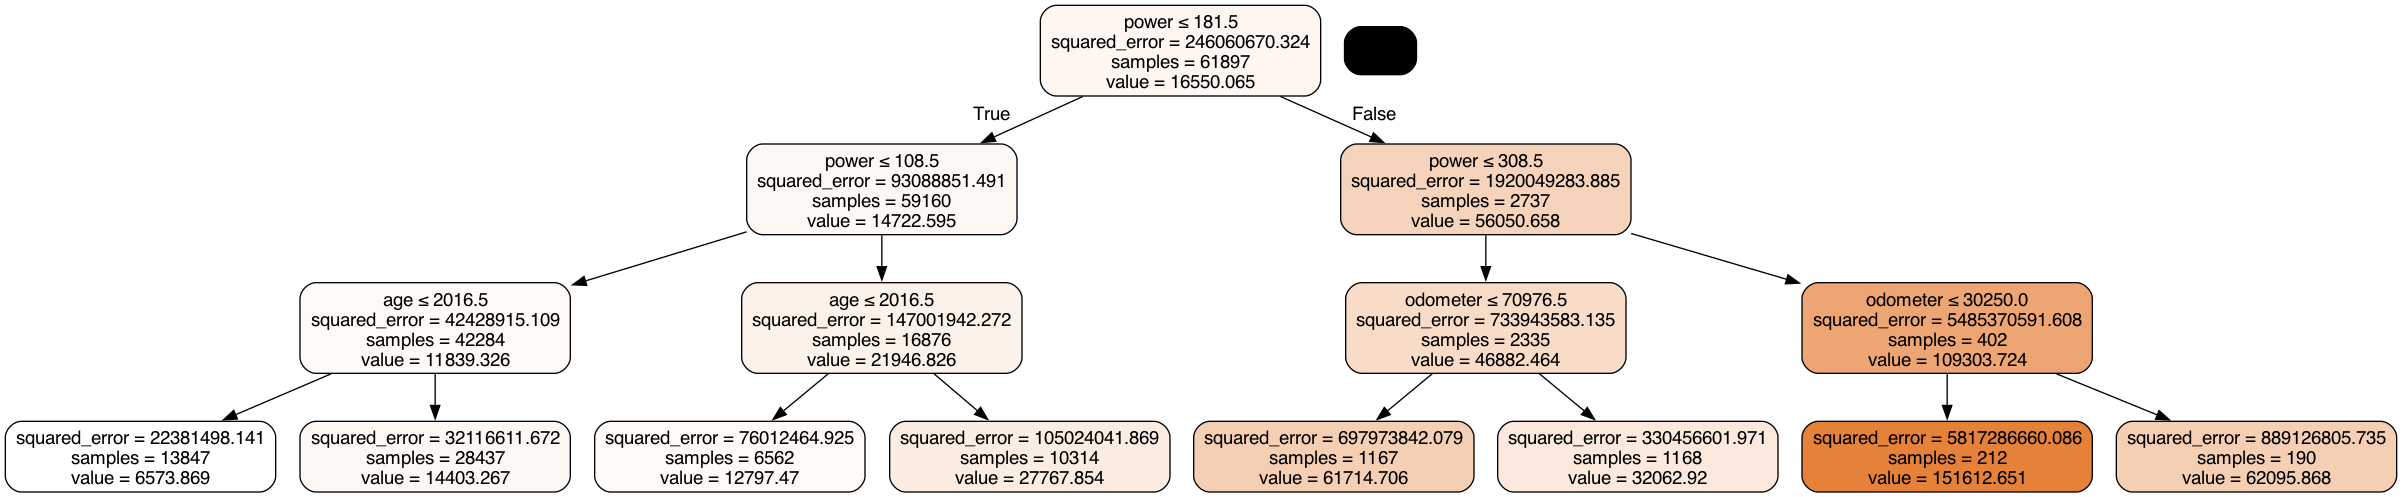

In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import pydotplus
from io import StringIO
from IPython.display import Image  # Import Image from IPython.display

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, used_new['price'], test_size=0.33, random_state=42)

# Create and fit the Decision Tree Regressor
my_DT = tree.DecisionTreeRegressor(max_depth=3)
my_DT.fit(X_train, y_train)
y_pred_dt = my_DT.predict(X_test)

# Evaluate the model
print('The Score on the test set with a basic decision tree regressor is:', my_DT.score(X_test, y_test))
print("The Root Mean squared error with a basic decision tree regressor: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_dt)))

# Create a visualization of the decision tree and save it to a file
dot_data = StringIO()
export_graphviz(my_DT, out_file=dot_data, feature_names=features_final.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("decision_tree.png")  # Save the visualization to a file

# Display the saved decision tree visualization using the Image module
Image(filename="decision_tree.png")


In [40]:
trknn_scores=[]
teknn_scores= []
rmse_scores=[]
for i in np.arange(1,20,1):
    my_DT = tree.DecisionTreeRegressor(max_depth=i,random_state=42)
    my_DT.fit(X_train, y_train)
    y_pred_dt = my_DT.predict(X_test)
    train_scores = my_DT.score(X_train,y_train)
    test_scores = my_DT.score(X_test,y_test)
    # The Root mean squared error
    trknn_scores.append(train_scores)
    teknn_scores.append(test_scores)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_dt)))

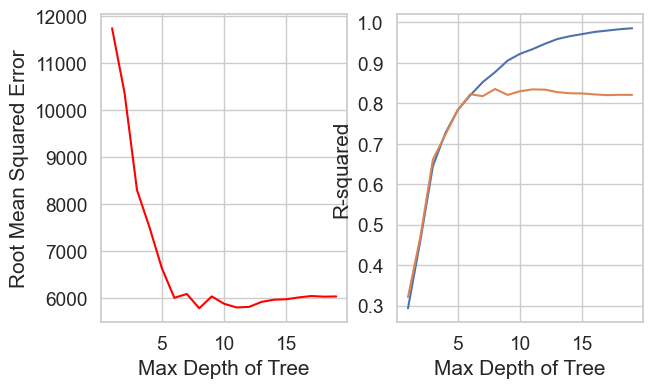

In [41]:
sns.set_style('whitegrid')
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(7,4));
ax1.plot(np.arange(1,20,1),rmse_scores,color='red');
ax2.plot(np.arange(1,20,1),trknn_scores);
ax2.plot(np.arange(1,20,1),teknn_scores);
ax1.set_xlabel('Max Depth of Tree')
ax2.set_xlabel('Max Depth of Tree')
ax1.set_ylabel('Root Mean Squared Error')
ax2.set_ylabel('R-squared');

In [42]:
from sklearn import tree
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(features_final, used_new['price'], test_size=0.33, random_state=42)
my_DT = tree.DecisionTreeRegressor(max_depth=8,random_state=42)
my_DT.fit(X_train, y_train)
y_pred_dt = my_DT.predict(X_test)
print('The Score on the training set with a decision tree regressor is:',my_DT.score(X_train,y_train))
print('The Score on the test set with a decision tree regressor is:',my_DT.score(X_test,y_test))
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_dt)))

The Score on the training set with a decision tree regressor is: 0.8772708804008376
The Score on the test set with a decision tree regressor is: 0.8353329544337932
Mean squared error: 5783.88


# Linear Regression Model

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Create and fit the StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Create and fit the Linear Regression model
lreg = LinearRegression()
lreg.fit(X_train, y_train)
y_pred_linear = lreg.predict(X_test)

# Evaluate the Linear Regression model
print('The Score on the test set with a linear regression is:', lreg.score(X_test, y_test))
# The Root Mean Squared Error
print("Root Mean Squared Error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_linear)))


The Score on the test set with a linear regression is: 0.7833717157006708
Root Mean Squared Error: 6633.97


# KNN Regressor

In [44]:
from sklearn.neighbors import KNeighborsRegressor

# Assuming you have already split your data into X_train, X_test, y_train, y_test

KNR = KNeighborsRegressor()

trknn_scores = []
teknn_scores = []
rmse_scores = []

for i in np.arange(1, 100, 5):
    KNR = KNeighborsRegressor(n_neighbors=i)
    KNR.fit(X_train, y_train)
    KNR.score(X_test, y_test)
    train_scores = KNR.score(X_train, y_train)
    test_scores = KNR.score(X_test, y_test)
    # The Root mean squared error
    trknn_scores.append(train_scores)
    teknn_scores.append(test_scores)
    y_pred_knn = KNR.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_knn)))


The above code took a significant execution time delays because it involves a loop that traverses a range of `n_neighbors` values in a KNeighborsRegressor model, calculating different scores and root mean squared errors. Specifically, it used a range defined as `np.arange(1, 100, 5)`, which implies that the loop covered values from 1 to 99, incrementing by 5 at each step.

Text(0, 0.5, 'R-squared')

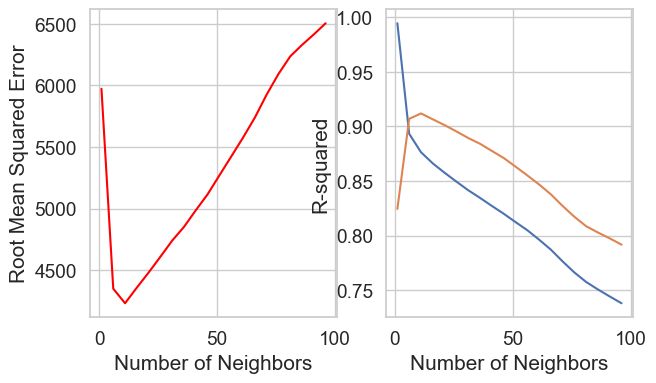

In [45]:
sns.set_style('whitegrid')
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(7,4))
ax1.plot(np.arange(1,100,5),rmse_scores,color='red')
ax2.plot(np.arange(1,100,5),trknn_scores)
ax2.plot(np.arange(1,100,5),teknn_scores)
ax1.set_xlabel('Number of Neighbors')
ax2.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Root Mean Squared Error')
ax2.set_ylabel('R-squared')


In [46]:
KNR = KNeighborsRegressor(n_neighbors=6)
KNR.fit(X_train,y_train)
y_pred_KNR = KNR.predict(X_test)
print('The Score on the test set with a KNN regressor is:',KNR.score(X_test,y_test))
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_KNR)))

The Score on the test set with a KNN regressor is: 0.9068651883541627
Mean squared error: 4349.83


# Random Forest Regressor

In [47]:
#Random Forest Regressor 
from sklearn.ensemble import RandomForestRegressor
rand_est = RandomForestRegressor()
rand_est.fit(X_train,y_train)
y_pred = rand_est.predict(X_test)
print(' The Score on the test set with a random forest regressor is:', rand_est.score(X_test,y_test))
#pretty good score dude 
# The Root mean squared error
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))

 The Score on the test set with a random forest regressor is: 0.9073880007288752
Mean squared error: 4337.60


We tried to optimized the RFR previously and we got the paremeters below

In [48]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = RFR, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected versi

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.2min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time= 2.4min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 4.2min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.2min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time= 2.4min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 4.2min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.2min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 2.9min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.1min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 2.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.2min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.2min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 4.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 2.9min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time= 2.4min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.0min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 2.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=25.3min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 5.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=25.3min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 5.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.2min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=45.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.2min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=45.3min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 2.9min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=45.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 4.1min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 4.2min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=34.5min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 4.3min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 3.4min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=13.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 3.7min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=14.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 5.4min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 4.7min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 3.3min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=14.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=25.0min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=35.1min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=10.7min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 4.8min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=43.3min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 4.8min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=43.4min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 3.8min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=43.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 9.9min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=10.7min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 7.2min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time= 3.2min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time= 3.1min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 6.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 7.6min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 7.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=43.3min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 2.6min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 8.3min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 7.1min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time= 3.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=25.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 7.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=26.6min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 7.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=26.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time= 2.6min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time= 2.6min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time= 3.9min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time= 3.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time= 2.6min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time= 3.8min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time= 3.9min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time= 3.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 4.0min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 4.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 2.1min
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=45.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 2.6min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 2.1min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 2.1min
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=45.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time= 3.5min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 4.0min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.9min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 4.5min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=11.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 2.7min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 2.6min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=11.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 2.8min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=34.6min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 3.8min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 3.2min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 2.3min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 2.3min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 2.4min
[CV] END bootstrap=False, max_depth=11

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.2min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.2min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  54.7s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 3.5min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 1.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.5min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  55.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.1min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 1.5min
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 2.6min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 2.6min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 2.5min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.2min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 1.8min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 3.5min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 1.5min
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 2.6min
[CV] END bootstrap=False, max_depth=110,

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=10.6min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 3.5min
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=27.7min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 2.5min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=37.5min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 4.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 2.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=10.6min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 2.7min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  56.5s
[CV] END bootstrap=False, max_depth=9

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.2min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 4.6min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=40.2min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=22.5min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 6.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 4.5min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=45.1min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 6.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=45.3min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 6.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=43.6min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=37.3min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.8min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 4.6min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 2.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=10.7min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.5min
[CV] END bootstrap=True, max_depth=9

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 2.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=17.8min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 3.2min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  41.4s


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=40.1min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=22.8min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=23.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=22.7min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=24.0min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=22.8min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=23.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 2.3min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=18.0min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=20.2min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 2.3min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=18.0min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 3.2min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 3.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  30.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=21.3min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=20.4min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=26.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 3.4min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 3.4min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=21.4min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 3.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=21.6min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 4.5min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 4.6min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=21.6min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 4.5min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=27.0min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=19.7min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=27.1min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=19.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=19.9min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 5.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  40.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  40.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  29.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  30.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=21.4min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=34.1min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 5.7min
[CV] END bootstrap=True, max_depth=60, ma

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 5.7min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 2.7min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 4.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 2.7min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 9.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 9.1min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 4.2min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 9.1min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time= 1.5min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time= 1.5min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 4.2min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=34.4min
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=21.2min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=44.3min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 1.8min
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=27.3min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=22.3min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=22.8min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=19.9min
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=21.8min
[CV] END bootstrap=False, max_dep

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 4.1min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 5.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 5.7min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 5.9min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 1.3min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.4min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 7.7min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 1.3min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 1.3min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.4min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 7.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=21.3min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 7.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=43.6min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=12.8min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=17.9min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.1min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.1min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 2.6min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 2.4min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=17.9min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.1min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.9min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.9min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 1.7min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time= 3.8min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.4min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 1.6min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 2.3min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=12.9min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.1min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 2.6min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.1min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time= 3.8min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.4min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 1.6min
[CV] END bootstrap=True, max_depth=40

/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=44.0min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=43.4min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=43.8min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.4min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=43.7min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time= 3.7min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.9min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 7.6min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 2.2min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time= 9.4min


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time= 9.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.6min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 7.6min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 2.2min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=18.2min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 2.2min
[CV] END bootstrap=False, max_depth=

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

The above code ran several hours since it is performing a randomized search for hyperparameter tuning on a RandomForestRegressor model. It's attempting to find the best combination of hyperparameters from a defined search space. Remember that hyperparameter tuning can be a time-consuming process, especially when dealing with complex models and large datasets. 

In [49]:
print('These are the best parameters from the randomized search:{max_depth: 40, n_estimators: 600, min_samples_split: 10, min_samples_leaf: 1, bootstrap: False, max_features: sqrt}')

These are the best parameters from the randomized search:{max_depth: 40, n_estimators: 600, min_samples_split: 10, min_samples_leaf: 1, bootstrap: False, max_features: sqrt}


In [50]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(features_final, used_new['price'], test_size=0.33, random_state=42)
rand_est = RandomForestRegressor(max_depth=40, n_estimators= 600, min_samples_split= 10, min_samples_leaf= 1, bootstrap= False, max_features= 'sqrt')
rand_est.fit(X_train,y_train)
y_pred_rfr = rand_est.predict(X_test)
print(' The Score on the train set with a hyperparameter optimized random forest regressor is:',rand_est.score(X_train,y_train))
print(' The Score on the test set with a hyperparameter optimized random forest regressor is:',rand_est.score(X_test,y_test))
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_rfr)))

 The Score on the train set with a hyperparameter optimized random forest regressor is: 0.9447691922364366
 The Score on the test set with a hyperparameter optimized random forest regressor is: 0.9306952666875629
Mean squared error: 3752.30


In [51]:
feature_importances = pd.DataFrame(rand_est.feature_importances_)
print(feature_importances.sort_values(by=0,ascending=False).head(10))

            0
1    0.240095
2    0.132876
0    0.129218
27   0.082020
284  0.070051
71   0.058622
4    0.026255
133  0.025397
292  0.017707
298  0.012694


Analyzing Feature Importances for highest scoring model

In [52]:
pd.Series(x).reset_index()[0]

0    0               Bmw
1              Audi
2     ...
1    0      diesel
1    gasoline
2      hybrid
3   ...
2    0            manual
1         automatic
2     ...
Name: 0, dtype: object

In [53]:
for i in feature_importances.sort_values(by=0,ascending=False).tail(5).index:
    print(features_final.columns[i])
    

Model_RomeoMito
Model_C3Picasso
Model_GrandVitara
manufacturer_Suzuki
Model_Duster


# XgBoost Regressor

In [54]:
from xgboost import XGBRegressor

xgbr = XGBRegressor()
xgbr.fit(X_train,y_train)
y_pred_xgbr = xgbr.predict(X_test)
print(xgbr)
print('The Score on the test set with an XGboost Regressor is:',xgbr.score(X_test,y_test))
print("Mean squared error: %.2f", np.sqrt(mean_squared_error(y_test,y_pred_xgbr)))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
The Score on the test set with an XGboost Regressor is: 0.8979740966499917
Mean squared error: %.2f 4552.72552943231


In [55]:
#Let's Optimize the XGBOOST - Run this overnight (I did this and it failed to return scores higher than the score above) )
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
xgbr = XGBRegressor()

max_depth = [3,5,10]
n_estimators = [500,600,800]
learning_rate = [0.15,0.3]
params = {
    #Hypeparameter tuning 
    'max_depth':max_depth,
    'n_estimators':n_estimators,
    'learning_rate':learning_rate}
xgbr_random = RandomizedSearchCV(estimator = xgbr, param_distributions = params, n_iter = 4, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgbr_random.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/rohith-9641/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected versi

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
           

In [56]:
print('These are the best parameters from the randomized search (Xgboost) :{max_depth: 5, n_estimators: 500, min_samples_split: 10, learning_rate=0.2}')

These are the best parameters from the randomized search (Xgboost) :{max_depth: 5, n_estimators: 500, min_samples_split: 10, learning_rate=0.2}


In [57]:
# Using the best parameters from randomized search
xgbr = XGBRegressor(learning_rate= 0.2, max_depth= 5, n_estimators= 500)
xgbr.fit(X_train,y_train)
y_pred = xgbr.predict(X_test)
print(xgbr)
print('The Score on the test set with an XGboost Regressor is:',xgbr.score(X_test,y_test))
print("Mean squared error: %.2f", np.sqrt(mean_squared_error(y_test,y_pred)))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
The Score on the test set with an XGboost Regressor is: 0.8953962711393973
Mean squared error: %.2f 4609.882198598748
[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=600; total time=   8.7s
[CV] END ..learning_rate=0.15, max_depth=3, n_estimators=60

# Model Comparison

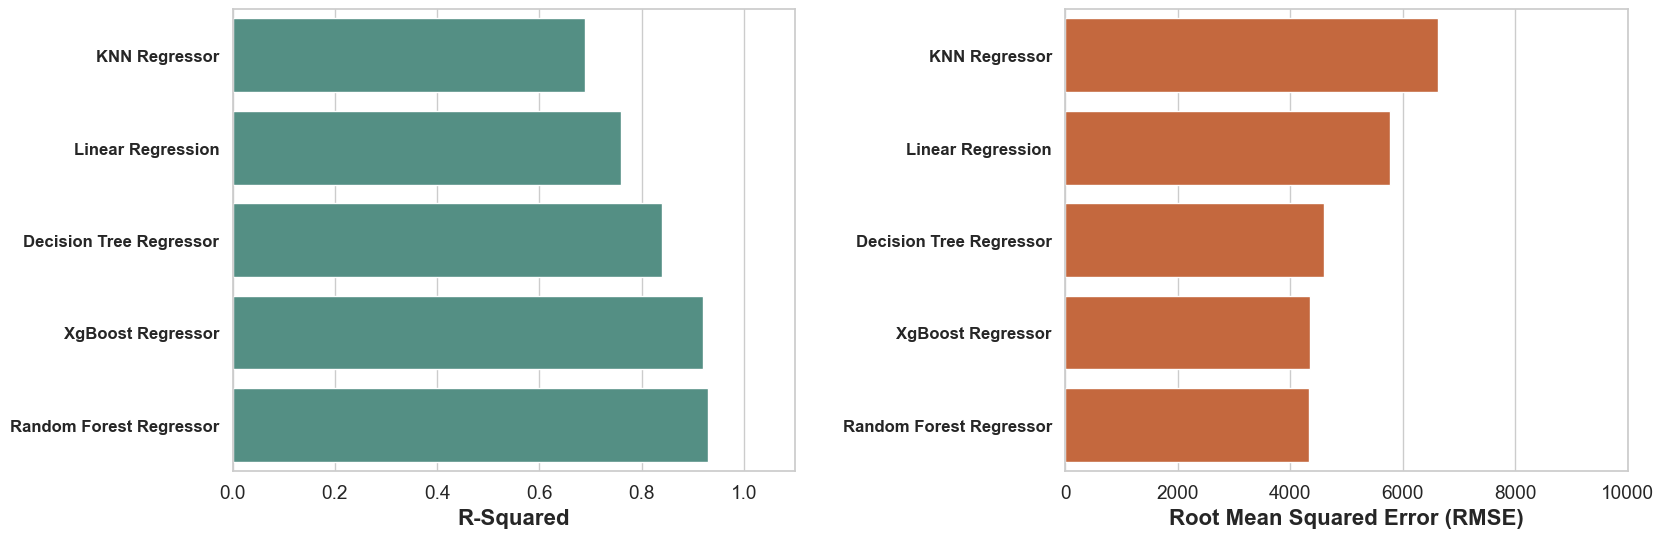

In [58]:
# Plot Model Results 
R_Squared = [0.69,0.76,0.84,0.92,0.93]
Model = ['KNN Regressor','Linear Regression','Decision Tree Regressor','XgBoost Regressor','Random Forest Regressor']
RMSE = [6633.97,5783.88,4609.88,4349.83,4337.60]

f, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18, 6));
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.48, hspace=None)
sns.set(style="white");
sns.barplot(y=Model, x=R_Squared,orient='h',label="R-Squared",ax=ax1,color='#4a998a');
ax1.set_xlabel("R-Squared",fontweight='bold',fontsize=16);
ax1.set_yticklabels(Model,fontweight='bold',fontsize=12)
ax1.set_xlim(0,1.1)
sns.barplot(y=Model, x=RMSE ,orient='h',label="Root Mean Squared Error",ax=ax2,color='#da5f28');
ax2.set_yticklabels(Model,fontweight='bold',fontsize=12)
ax2.set_xlabel('Root Mean Squared Error (RMSE)',fontweight='bold',fontsize=16);
ax2.set_xlim(0,10000)
plt.savefig('ctscores2.png',dpi=400)

# Plotting Residuals vs Fitted Values

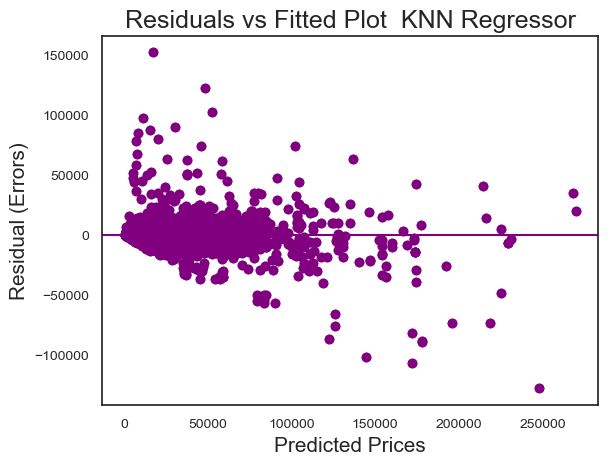

In [59]:
##KNN regressor
def residuals(prediction,colz,title):
    sns.set_style("white")
    Residual = y_test - prediction
    plt.scatter(prediction, Residual,color=str(colz))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('Predicted Prices',fontsize=15)
    plt.ylabel('Residual (Errors)',fontsize=15)
    plt.axhline(y=0,color=str(colz))
    plt.title('Residuals vs Fitted Plot  '+ str((title)),fontsize=18)
    x = plt.scatter(prediction,Residual,color=str(colz))
    return x 

residuals(y_pred_KNR,'purple','KNN Regressor')

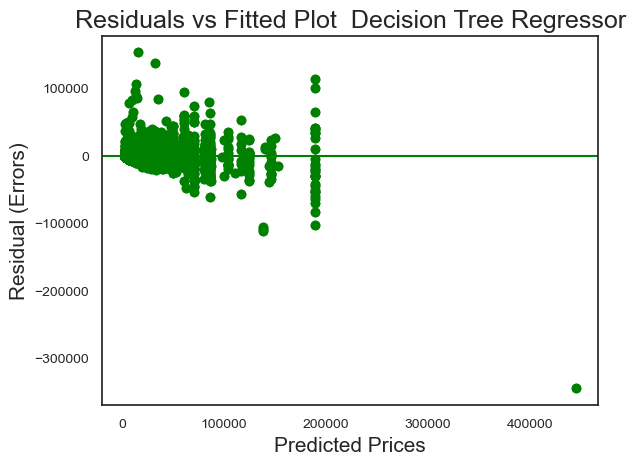

In [60]:
### Decision Tree Residuals
residuals(y_pred_dt,'green','Decision Tree Regressor')

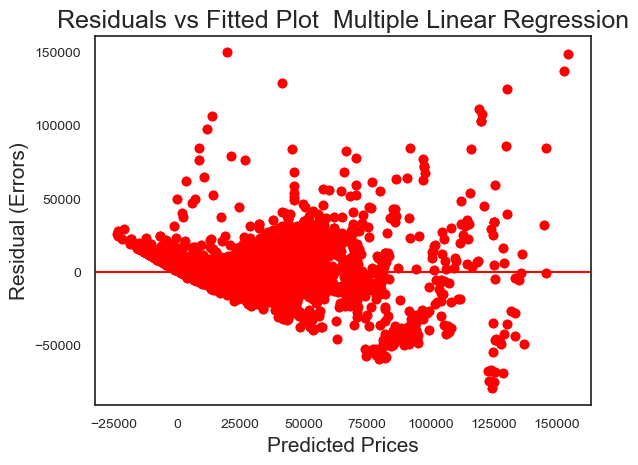

In [61]:
#Multiple Linear Regression
residuals(y_pred_linear,'red', 'Multiple Linear Regression')

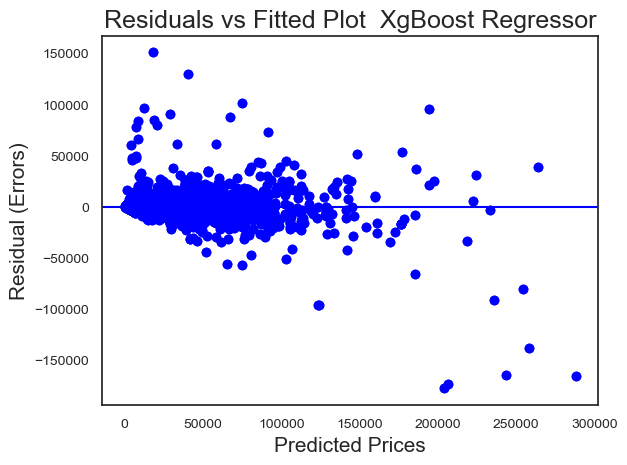

In [62]:
residuals(y_pred_xgbr,'blue','XgBoost Regressor')

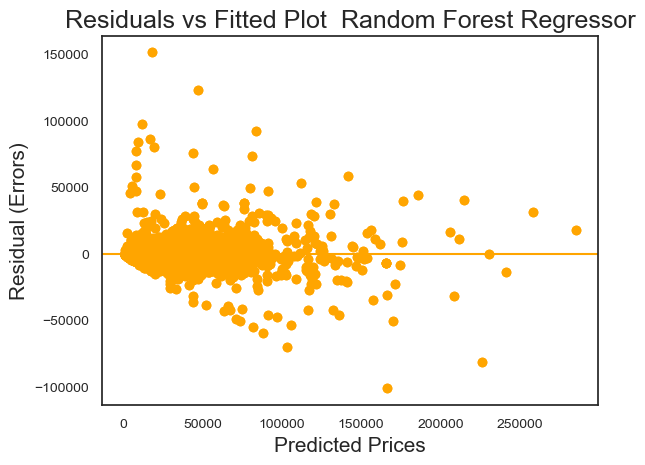

In [63]:
residuals(y_pred_rfr,'orange','Random Forest Regressor')